In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
from scipy.stats import linregress
import json
import pprint
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

# Import API key

from api_keys import api_key

In [2]:

# read in csv
oscar_data= pd.read_csv("Resources/oscar_data.csv")

In [3]:
all_nominees = oscar_data[["Year", "Best Picture", "Nominee 1", "Nominee 2", "Nominee 3", "Nominee 4"]]

#Can we do all nominees in every category just for one year as well?

In [4]:
base_url = "https://api.themoviedb.org/3/"
responseid = {'Title' : [],'ID' : [], 'Vote Average' : [], 'Release Date' : []}

#Enter year

years = ["2018", "2019", "2020"]

for year in years:
    startdate = f"{year}-01-01"
    enddate = f"{year}-12-31"

    all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}').json()
    total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

    #Request from API for each month
    for i in range(1,int(total_pages)//10):

    #EDIT DATES FOR DIFFERENT YEARS
        all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}&page={i}').json()
        
        #puts all results into a dictionary
        for j in range(len(all_movies_response["results"])):
            responseid['Title'].append(all_movies_response["results"][j]["title"])
            responseid['ID'].append(all_movies_response["results"][j]["id"])
            responseid['Vote Average'].append(all_movies_response["results"][j]["vote_average"])
            responseid['Release Date'].append(all_movies_response["results"][j]["release_date"])

In [5]:
#dictionary to dataframe, sorted and prepped for use

input_format = '%Y-%m-%d'
moviedata = pd.DataFrame(responseid)
# input string
moviedata['Release Date'] = pd.to_datetime(moviedata['Release Date'], utc=True)

moviedata['Release Date UNIX'] = moviedata['Release Date'].astype(np.int64)

moviedata = moviedata.sort_values("Release Date")
#moviedata['Release Date UNIX'] = (moviedata['Release Date'] - datetime(1970,1,1)).total_seconds()
moviedata['Day'] = moviedata['Release Date'].dt.day
moviedata['Month'] = moviedata['Release Date'].dt.strftime('%b')
moviedata['Month Number'] = moviedata['Release Date'].dt.month
moviedata['Year'] = moviedata['Release Date'].dt.year
moviedata = moviedata.reset_index(drop=True)

moviedata

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year
0,House of Deadly Secrets,523443,4.700,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018
1,Bees Make Honey,476634,4.706,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018
2,Grandpa's Great Escape,495737,5.900,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018
3,Mad World,520788,5.300,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018
4,Hippopotamus,516027,5.648,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018
...,...,...,...,...,...,...,...,...,...
4555,Pieces of a Woman,641662,7.030,2020-12-30 00:00:00+00:00,1609286400000000000,30,Dec,12,2020
4556,Yearly Departed,781188,4.147,2020-12-30 00:00:00+00:00,1609286400000000000,30,Dec,12,2020
4557,Sorry I Killed You,763820,5.857,2020-12-31 00:00:00+00:00,1609372800000000000,31,Dec,12,2020
4558,Shadow in the Cloud,675327,5.825,2020-12-31 00:00:00+00:00,1609372800000000000,31,Dec,12,2020


In [8]:
titles = moviedata['Title'].to_list()

years = ["2018", "2019", "2020"]
for year in years:
    noms = []
    for movie in titles:
        mask = oscar_data[oscar_data.apply(lambda row: row.astype(str).str.contains(re.escape(str(movie)), case=False).any(), axis=1)]
        if mask.empty:
            noms.append("No")
            
        else:
            if mask['Year'].values[0] == year:
                noms.append("Yes")
            else:
                noms.append("No")
                
    moviedata[f'Nominated {year}'] = noms



In [41]:
moviedata.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated 2018,Nominated 2019,Nominated 2020
0,House of Deadly Secrets,523443,4.700,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No,No,No
1,Bees Make Honey,476634,4.706,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No,No,No
2,Grandpa's Great Escape,495737,5.900,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No,No,No
3,Mad World,520788,5.300,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,No,No,No
4,Hippopotamus,516027,5.648,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,No,No,No


In [43]:
nominated_movies = moviedata.loc[(moviedata["Nominated 2018"] == "Yes") |
              (moviedata["Nominated 2019"] == "Yes") |
              (moviedata["Nominated 2020"] == "Yes"),:]

nominated_movies = nominated_movies.drop(columns=["Nominated 2018", "Nominated 2019", "Nominated 2020"])
nominated_movies.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year
50,"Hale County This Morning, This Evening",490785,5.893,2018-01-19 00:00:00+00:00,1516320000000000000,19,Jan,1,2018
66,End Game,510258,7.106,2018-01-21 00:00:00+00:00,1516492800000000000,21,Jan,1,2018
134,Black Panther,284054,7.386,2018-02-13 00:00:00+00:00,1518480000000000000,13,Feb,2,2018
278,Isle of Dogs,399174,7.848,2018-03-23 00:00:00+00:00,1521763200000000000,23,Mar,3,2018
290,Ready Player One,333339,7.603,2018-03-28 00:00:00+00:00,1522195200000000000,28,Mar,3,2018


In [52]:
nominated_movies.groupby(["Year", "Month Number"]).count()

Title  ID  Vote Average  Release Date  Release Date UNIX  \
Year Month Number                                                             
2018 1                 2   2             2             2                  2   
     2                 1   1             1             1                  1   
     3                 2   2             2             2                  2   
     4                 2   2             2             2                  2   
     5                 5   5             5             5                  5   
     6                 3   3             3             3                  3   
     8                 4   4             4             4                  4   
     9                 1   1             1             1                  1   
     10                3   3             3             3                  3   
     11                6   6             6             6                  6   
     12                4   4             4             4                  4   
2019 1                 3   3             3             3                  3   
     2                 2   2             2             2                  2   
     4                 5   5             5             5                  5   
     5                 1   1             1             1                  1   
     6                 1   1             1             1                  1   
     7                 1   1             1             1                  1   
     8                 4   4             4             4                  4   
     9                 5   5             5             5                  5   
     10                3   3             3             3                  3   
     11                5   5             5             5                  5   
     12                5   5             5             5                  5   
2020 1                 1   1             1             1                  1   
     2                 2   2             2             2                  2   
     3                 1   1             1             1                  1   
     6                 3   3             3             3                  3   
     7                 1   1             1             1                  1   
     8                 2   2             2             2                  2   
     9                 2   2             2             2                  2   
     10                3   3             3             3                  3   
     11                6   6             6             6                  6   
     12                5   5             5             5                  5   

                   Day  Month  Oscar Season  
Year Month Number                            
2018 1               2      2             2  
     2               1      1             1  
     3               2      2             2  
     4               2      2             2  
     5               5      5             5  
     6               3      3             3  
     8               4      4             4  
     9               1      1             1  
     10              3      3             3  
     11              6      6             6  
     12              4      4             4  
2019 1               3      3             3  
     2               2      2             2  
     4               5      5             5  
     5               1      1             1  
     6               1      1             1  
     7               1      1             1  
     8               4      4             4  
     9               5      5             5  
     10              3      3             3  
     11              5      5             5  
     12              5      5             5  
2020 1               1      1             1  
     2               2      2             2  
     3               1      1             1  
     6               3      3             3  
     7               1      1             1 

In [53]:
season = []

for row in nominated_movies['Month']:
    if row in ("Nov", "Dec"):
        season.append("Yes")
    else:
        season.append("No")

nominated_movies['Oscar Season'] = season
nominated_movies

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Oscar Season
50,"Hale County This Morning, This Evening",490785,5.893,2018-01-19 00:00:00+00:00,1516320000000000000,19,Jan,1,2018,No
66,End Game,510258,7.106,2018-01-21 00:00:00+00:00,1516492800000000000,21,Jan,1,2018,No
134,Black Panther,284054,7.386,2018-02-13 00:00:00+00:00,1518480000000000000,13,Feb,2,2018,No
278,Isle of Dogs,399174,7.848,2018-03-23 00:00:00+00:00,1521763200000000000,23,Mar,3,2018,No
290,Ready Player One,333339,7.603,2018-03-28 00:00:00+00:00,1522195200000000000,28,Mar,3,2018,No
...,...,...,...,...,...,...,...,...,...,...
4404,Scarlett,816614,7.139,2020-12-01 00:00:00+00:00,1606780800000000000,1,Dec,12,2020,Yes
4484,Promising Young Woman,582014,7.443,2020-12-13 00:00:00+00:00,1607817600000000000,13,Dec,12,2020,Yes
4544,News of the World,581032,7.000,2020-12-25 00:00:00+00:00,1608854400000000000,25,Dec,12,2020,Yes
4546,One Night in Miami...,661914,7.000,2020-12-25 00:00:00+00:00,1608854400000000000,25,Dec,12,2020,Yes


In [81]:
nominated_movies_grouped = nominated_movies.groupby(["Year", "Oscar Season"]).count()
nominated_movies_grouped = nominated_movies_grouped.reset_index()
nominated_movies_grouped

,Year,Oscar Season,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number
0,2018,No,23,23,23,23,23,23,23,23
1,2018,Yes,10,10,10,10,10,10,10,10
2,2019,No,25,25,25,25,25,25,25,25
3,2019,Yes,10,10,10,10,10,10,10,10
4,2020,No,15,15,15,15,15,15,15,15
5,2020,Yes,11,11,11,11,11,11,11,11


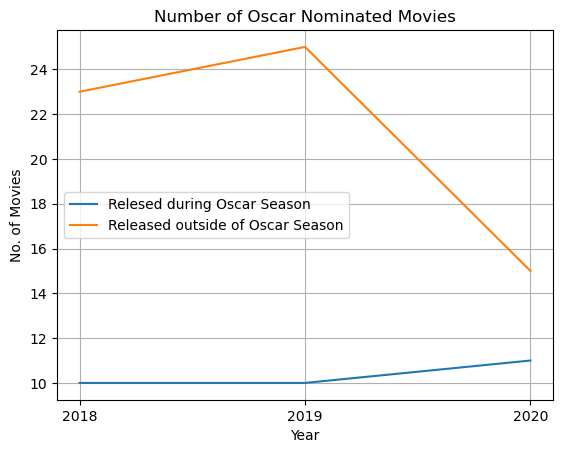

In [108]:
x_values = nominated_movies_grouped["Year"].unique().tolist()
y_values_oscar_season = nominated_movies_grouped.loc[nominated_movies_grouped["Oscar Season"] == "Yes","Title"].tolist()
y_values_non_oscar_season = nominated_movies_grouped.loc[nominated_movies_grouped["Oscar Season"] == "No","Title"].tolist()

tick_locations = [x for x in x_values]

plt.plot(x_values, y_values_oscar_season, label="Relesed during Oscar Season")
plt.plot(x_values, y_values_non_oscar_season, label="Released outside of Oscar Season")

plt.xticks(tick_locations, x_values)
plt.xlabel("Year")
plt.ylabel("No. of Movies")

plt.title("Number of Oscar Nominated Movies")
plt.grid(True)
plt.legend(loc="best")
plt.show()